## Udacity Project Prosper Loan Data Visualization (April 2019)
### Karen Chang

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
prosper = pd.read_csv('https://www.dropbox.com/s/meif3cqa75ddrqa/prosperLoanData.csv?dl=1')

In [3]:
pd.options.display.max_columns = None

## Step 1:Data Assessment
•	Quality Issue:  
a)	Remove duplicated lines based on **ListingKey**.  
b)	Erroneous datatypes (**ListingCreationDate, ClosedDate, DateCreditPulled, LoanOriginationDate**), change data type from object to datetime. 

•	Tidiness Issue:  
a)	Consolidate two types of credit grades **CreditGrade** (before 2009) and **ProsperRatingAlpha** (after 2009) into a new column called **NewGrade**.

In [4]:
prosper.drop_duplicates('ListingKey', inplace = True)

In [5]:
prosper['ListingCreationDate'] = pd.to_datetime(prosper['ListingCreationDate'])
prosper['ClosedDate'] = pd.to_datetime(prosper['ClosedDate'])
prosper['DateCreditPulled'] = pd.to_datetime(prosper['DateCreditPulled'])
prosper['LoanOriginationDate'] = pd.to_datetime(prosper['LoanOriginationDate'])

In [6]:
prosper.rename(columns = {'ProsperRating (Alpha)':'ProsperRatingAlpha'}, inplace = True)

In [7]:
prosper['NewGrade'] = prosper['CreditGrade'].fillna(prosper['ProsperRatingAlpha'])

## Step 2: Data Wrangling 

•	To understand the profitability of each loan, we create a new variable with the following formula: 

**loanprofit** = **LenderYield** * **LoanOriginalAmount** – **AmountDelinquent**

•	Remove loans without BorrowerAPR (25 loans in 2005 are identified).

•	To perform trend analysis, we will create new variables called **LoanOriginationYear**/**LoanOriginationMonth**  (data extracted from **LoanOriginationDate**)

•	To understand the Yield Amount of each loan, we create another new variable:

**yieldamount** = **LenderYield** * **LoanOriginalAmount**

However, it’s noted that there are 4,635 lines where **AmountDelinquent** is more than **LoanOriginalAmount**. So we created another new column to identify these exceptions:  

* **ReasonableResult** = **LoanOriginalAmount** > **AmountDelinquent**


### What is the structure of your dataset?

This data is provided by Udacity. The data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. The period of this data set is for loans created during 09 Nov 2005 and 11 Mar 2014.
In this project, we will perform data analysis to help Prosper to increase the gains on future loans and have better targeting on potential good customers in the future.


### What is/are the main feature(s) of interest in your dataset?

In this project, we will perform data analysis to help Prosper to: 

1) increase the profitability on future loans

2) grow revenue by having better targeting on potential good customers in the future.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

As we would like to understand the performance of the gains/profits on loans, the following variables are important features for us to investigate: 

1) **Feature of loan profit** : We made the calculation of loan profit by considering LenderYield, LoanOriginalAmount and AmountDelinquent (excluded exceptional cases where LoanOriginalAmount is less than AmountDelinquent). The calculation goes like this:
loan profit = LenderYield * LoanOriginalAmount – AmountDelinquent 

2) **Feature of Credit Rating**: The credit rating is a crucial indicator to classify borrowers. Through the analysis between Credit Rating and other variables, we would like to investigate the appropriateness of credit rating at Prosper.


In [8]:
prosper['loanprofit'] = prosper['LenderYield']*prosper['LoanOriginalAmount']- prosper['AmountDelinquent']

In [9]:
prosper['ReasonableResult'] = prosper['LoanOriginalAmount'] > prosper['AmountDelinquent']

## Univariate Exploration

In this section, we will look into the distribution/trend of the following variables: 

Plot 1 **StatedMonthlyIncome**

Plot 2 **loanprofit**

Plot 3 **BankcardUtilization**|

Plot 4 **BorrowerState**

### Plot 1 **StatedMonthlyIncome**
It's the monthly income the borrower stated at the time the listing was created.

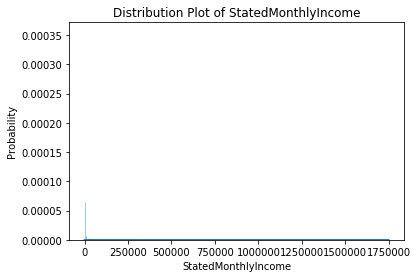

In [10]:
bins = np.arange(100, prosper['StatedMonthlyIncome'].max(),100)
sb.distplot(prosper['StatedMonthlyIncome'], bins)
plt.title('Distribution Plot of StatedMonthlyIncome')
plt.xlabel('StatedMonthlyIncome')
plt.ylabel('Probability');

In [11]:
prosper['StatedMonthlyIncome'].describe()

count    1.130660e+05
mean     5.605120e+03
std      7.495596e+03
min      0.000000e+00
25%      3.199396e+03
50%      4.666667e+03
75%      6.824688e+03
max      1.750003e+06
Name: StatedMonthlyIncome, dtype: float64

Due to the significant deviation of StatedMonthlyIncome (min \$ 0 and max 1,750,000), the result from the above distribution plot is not easy to see the overview of MonthlyIncome. 

To have a better overview of StatedMonthlyIncome, we will use percentile 95% which drop the top 5% of (exceptional) MonthlyIncome.

In [12]:
a = prosper['StatedMonthlyIncome']
np.percentile(a,95)

12250.0

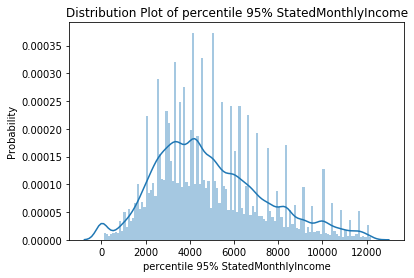

In [13]:
bins = np.arange(100, 12250,100)
prosper_95monthlyincome = prosper.query('StatedMonthlyIncome < 12250').StatedMonthlyIncome
sb.distplot(prosper_95monthlyincome, bins, axlabel = 'percentile 95% StatedMonthlyIncome')
plt.title('Distribution Plot of percentile 95% StatedMonthlyIncome')
plt.xlabel('percentile 95% StatedMonthlyIncome')
plt.ylabel('Probability');

In [14]:
prosper_95monthlyincome.describe()

count    107402.000000
mean       4919.007018
std        2487.310003
min           0.000000
25%        3116.666667
50%        4543.125000
75%        6416.666667
max       12241.666667
Name: StatedMonthlyIncome, dtype: float64

**StatedMonthlyIncome**: Due to several of outliers on Monthly Income, such as USD 1,750,000, USD 600,000, a distribution plot is performed according to data with percentile 95% (USD 12,250). The data has the shape of a normal distribution with slight right skewed trend indicates with peak at around USD 4,000 with mean USD 4,919 and median USD 4,543. 

According to https://www.worlddata.info/average-income.php which provides world average salary per 2017, the average monthly salary in USA is USD 4,930. We can see that people with monthly salary lower than USD 5,000 are highly possible to apply loans.

### Plot 2 **loanprofit**

It's the difference between **LenderYield** * **LoanOriginalAmount** and **AmountDelinquent**.

In [15]:
prosper['loanprofit'].describe()

count    105444.000000
mean        416.435335
std        7232.851903
min     -462865.400000
25%         531.000000
50%        1090.800000
75%        1870.000000
max        8500.000000
Name: loanprofit, dtype: float64

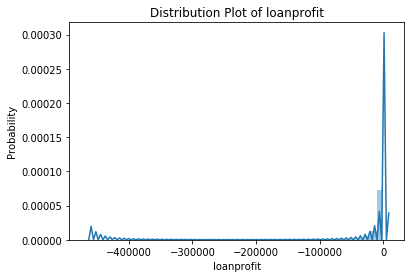

In [16]:
prosper_loanprofit = prosper['loanprofit']
bins = np.arange(-470000, prosper['loanprofit'].max(),10000)
sb.distplot(prosper['loanprofit'].dropna(), bins)
plt.title('Distribution Plot of loanprofit')
plt.xlabel('loanprofit')
plt.ylabel('Probability');

In [17]:
prosper['AmountDelinquent'] = prosper['AmountDelinquent'].replace(np.nan,0)

Due to the significant difference between min and max loanprofit, the distribution graph didn't give a clear overview. Moreover, it's strange to see cases where **LoanOriginalAmount** is even less than **AmountDelinquent**. However, we don't have further information to justify.
In order to have a more clear distribution, we will filter out exceptional cases where **LoanOriginalAmount** is even less than **AmountDelinquent**.

In [18]:
prosper['ReasonableResult'] = prosper['LoanOriginalAmount'] > prosper['AmountDelinquent']

In [19]:
# After NaN is filled with zero at ['AmountDelinquent'], we recalculate ['loanprofit']
prosper['loanprofit'] = prosper['LenderYield']*prosper['LoanOriginalAmount']- prosper['AmountDelinquent']

In [20]:
prosper.query('ReasonableResult == False').LoanOriginalAmount.count()

4635

In [21]:
prosper.query('ReasonableResult == True')['loanprofit'].describe()

count    108431.000000
mean       1257.156273
std        1191.191706
min      -19285.500000
25%         574.500000
50%        1099.600000
75%        1870.000000
max        8500.000000
Name: loanprofit, dtype: float64

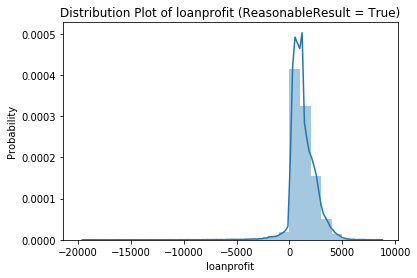

In [22]:
prosper_reasonable_loanprofit = prosper.query('ReasonableResult == True')['loanprofit']
bins = np.arange(-20000, prosper_reasonable_loanprofit.max(),1000)
sb.distplot(prosper_reasonable_loanprofit, bins)
plt.title('Distribution Plot of loanprofit (ReasonableResult = True)')
plt.xlabel('loanprofit')
plt.ylabel('Probability');

**loanprofit**: As mentioned earlier, we noted 4,635 exceptional cases where **LoanOriginalAmount** is lower than **AmountDelinquent**. Thus after dropping these exceptions, the distribution plot is slightly right skewed and shows that the majority of loanprofit is under USD 2,000 with median USD 1,099 and mean USD 1,257. Thus, for each loan, we may expect to have gain for around USD 1-2K. 

In the next section, we will investigate further about the relationship between **loanprofit** and other variables.

### Plot 3 **BankcardUtilization**:
It's the percentage of available revolving credit that is utilized at the time the credit profile was pulled.

In [23]:
prosper['BankcardUtilization'].describe()

count    105462.000000
mean          0.561088
std           0.318189
min           0.000000
25%           0.310000
50%           0.600000
75%           0.840000
max           5.950000
Name: BankcardUtilization, dtype: float64

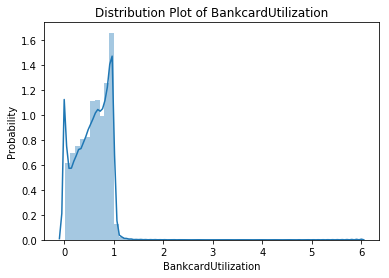

In [24]:
bins = np.arange(0.01, 5.95,0.1)
plt.title('Plot of BankcardUtilization')
sb.distplot(prosper['BankcardUtilization'].dropna(), bins)
plt.title('Distribution Plot of BankcardUtilization')
plt.xlabel('BankcardUtilization')
plt.ylabel('Probability');

Due to the significant difference between min and max at variable **BankcardUtilization**, the distribution graph didn't give a clear overview. Moreover, it's strange to see cases where the values at **BankcardUtilization** is even higher than 100%. 
However, we don't have further information to justify.
In order to have a more clear distribution, we will filter out **BankcardUtilization** with value more than 1.

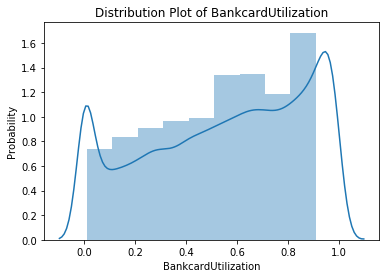

In [25]:
bins = np.arange(0.01, 1,0.1)
prosper_BankcardUtilization = prosper.query('BankcardUtilization <=1').BankcardUtilization
plt.title('Plot of BankcardUtilization')
sb.distplot(prosper_BankcardUtilization, bins)
plt.title('Distribution Plot of BankcardUtilization')
plt.xlabel('BankcardUtilization')
plt.ylabel('Probability');

In [26]:
prosper_BankcardUtilization.describe()

count    103721.000000
mean          0.551761
std           0.310643
min           0.000000
25%           0.300000
50%           0.590000
75%           0.830000
max           1.000000
Name: BankcardUtilization, dtype: float64

**BankcardUtilization**: Due to several outlier of Utilization percentage (e.g., 5.95), we made a distribution plot based on Utilization percentage less than 100%. The result shows that significant number of borrowers utilized bank card 50%-80% with median 59% and mean 55%.


### Plot 4 **BorrowerState**

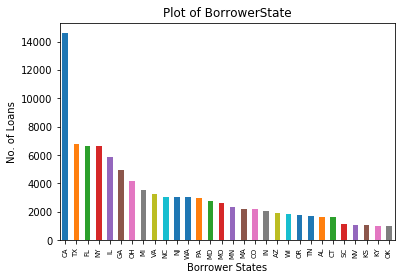

In [27]:
prosper_statesloan = prosper.groupby('BorrowerState').ListingKey.count().sort_values(ascending = False).head(30)
prosper_statesloan.plot(kind='bar')
plt.title('Plot of BorrowerState')
plt.xlabel('Borrower States')
plt.ylabel('No. of Loans')
plt.xticks(fontsize=7, rotation = 90);

In [28]:
prosper.BorrowerState.nunique()

51

Based on the histogram plot, we  can see CA (California) is the state with highest number of loans (12% of total number of loans). It’s reasonable as headquarter of Prosper is located at CA. TX is at the second place, followed by FL, NY and IL. These states have individually approximate 6% of total number of loans. In total, there are 51 states where all the borrowers are located.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

Following the previous analysis on Univariate Exploration, due to noted outliers or unusual results, we would like to make transformation for below variables:
1.	**StatedMonthlyIncome**: Due to several of outliers on Monthly Income, such as USD 1,750,000, USD 600,000, a distribution plot is performed according to data with percentile 95% (USD 12,250). 


2.	To understand the Yield Amount of each loan, we create a new column:
**prosper['yieldamount'] = prosper['LenderYield']* prosper['LoanOriginalAmount']**

However, it’s noted that there are 4,635 lines where ** AmountDelinquent** is more than ** LoanOriginalAmount**. So we created another new column to identify these exceptions:
**prosper['ReasonableResult'] = prosper['LoanOriginalAmount'] > prosper['AmountDelinquent']**

Thus, when performing further analysis, we use data based on ‘ReasonableResult == True’


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

1.	When performing scatter plots, it’s noted that due to several variables which include NaN in numeric columns, plotting is not working. Thus we use *dropna* function to proceed the visualization. For those numeric variables containing NaN are listed below: 

•	**AmountDelinquent** 

•	**BorrowerAPR** 

•	**BankcardUtilization**


2.	Credit grade is an important variable for our analysis. The provided credit grade is either before 2009 or after 2009. To have a complete overview on credit grades on all loans, We consolidate two types of credit grades **CreditGrade** (before 2009) and **ProsperRatingAlpha** (after 2009) into a new column called **NewGrade**.


3.	Remove duplicated lines based on **ListingKey**.  


4.	Correct erroneous datatypes (**ListingCreationDate, ClosedDate, DateCreditPulled, LoanOriginationDate**), change data type from object to datetime. So we can perform time series analysis.


## Bivariate Exploration

In this section, we will investigate the relationship between two variables for the following variables: 

Plot 1 **NewGrade vs. BankcardUtilization**

Plot 2 **LoanOriginationDate vs. BorrowerAPR.mean()**

Plot 3 **AmountDelinquent (> 30 Delinquent Days )vs. NewGrade**

Plot 4 **yieldamount vs. NewGrade**

Plot 5 **loanprofit vs. NewGrade**

Plot 6 **LoanOriginalAmount(LoanStatus =="Defaulted) vs. NewGrade**

Plot 7 **Defaulted Rate vs. BorrowerState**

### Plot 1 **NewGrade** vs. **BankcardUtilization**

NewGrade is the credit rating which was assigned when the loan is applied.

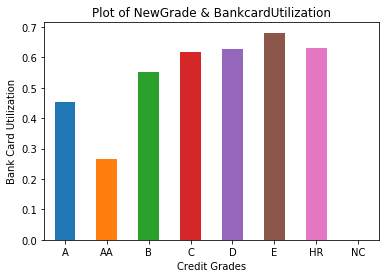

In [29]:
prosper_bankcardutilization = prosper.sort_values('NewGrade').groupby('NewGrade').BankcardUtilization.mean()  
prosper_bankcardutilization.plot(kind='bar')
plt.title('Plot of NewGrade & BankcardUtilization')
plt.xlabel('Credit Grades')
plt.ylabel('Bank Card Utilization')
plt.xticks(rotation = 0);

**NewGrade** vs. **BankcardUtilization**: It’s interesting but not surprising to see that that the lower credit grades, the higher percentage of **BankcardUtilization**. For example grade A/AA utilized bank card 28% - 45%, while the other grades utilized bank card around 55% - 68%.  

### Plot 2 **LoanOriginationDate** vs. **BorrowerAPR**.mean()

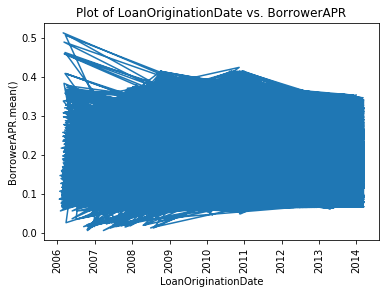

In [30]:
prosper_time = prosper.sort_values('LoanOriginationDate', ascending=True)
plt.plot(prosper['LoanOriginationDate'], prosper['BorrowerAPR'])
plt.title('Plot of LoanOriginationDate vs. BorrowerAPR')
plt.xlabel('LoanOriginationDate')
plt.ylabel('BorrowerAPR.mean()')
plt.xticks(rotation='vertical');

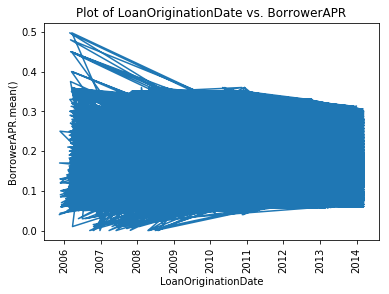

In [31]:
prosper_time = prosper.sort_values('LoanOriginationDate', ascending=True)
plt.plot(prosper['LoanOriginationDate'], prosper['BorrowerRate'])
plt.title('Plot of LoanOriginationDate vs. BorrowerAPR')
plt.xlabel('LoanOriginationDate')
plt.ylabel('BorrowerAPR.mean()')
plt.xticks(rotation='vertical');

In [32]:
# Due to the high volumes of data in various LoanOriginationDate, the above graphs doesn't give a clear overview on BorrowerRate's trend.
prosper_loandate = prosper.groupby('LoanOriginationDate').BorrowerAPR.mean()

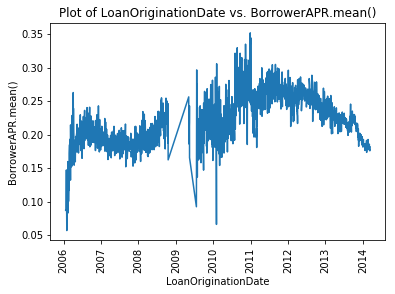

In [33]:
plt.plot(prosper_loandate)
plt.title('Plot of LoanOriginationDate vs. BorrowerAPR.mean()')
plt.xlabel('LoanOriginationDate')
plt.ylabel('BorrowerAPR.mean()')
plt.xticks(rotation='vertical');

In [34]:
prosper['LoanOriginationYear'] = prosper['LoanOriginationDate'].dt.year

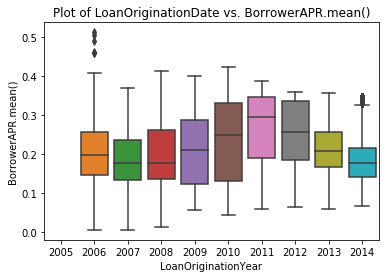

In [35]:
sb.boxplot( data= prosper, x= 'LoanOriginationYear', y = 'BorrowerAPR')
plt.title('Plot of LoanOriginationDate vs. BorrowerAPR.mean()')
plt.xlabel('LoanOriginationYear')
plt.ylabel('BorrowerAPR.mean()')
plt.show();

**LoanOriginationDate** vs. **BorrowerAPR**.mean(): Although in previous section we have discussed the yearly trend of **BorrowerAPR**, in this plot, based on the mean of **BorrowerAPR**, the trend of **BorrowerAPR** is more clear. The lower number of loans during 2009 and 2010, increased APR during 2009 and 2011 and afterwards APR is decreased.

Moreover, from boxplot, we can see that the deviation between maximum and minimum Interest Rate is the significant during 2009 and 2010 which is possibly explained by lower number of loans results in higher deviation. We can see the deviation has been decreased during 2011 and 2014. The trend of median BorrowerRate is increased during 2008 and 2011 but decreased afterwards. 

### Plot 3 **AmountDelinquent** (> 30 Delinquent Days )vs. **NewGrade**

In [36]:
prosper_delinquent = prosper.query('AmountDelinquent != 0').groupby('NewGrade',).AmountDelinquent.sum()
prosper_delinquent

NewGrade
A     10651034.0
AA     1811365.0
B     12652143.0
C     19592963.0
D     23741454.0
E     18427146.0
HR    17121169.0
Name: AmountDelinquent, dtype: float64

In [37]:
prosper_delinquent = prosper.query('AmountDelinquent != 0 & LoanCurrentDaysDelinquent > 30').groupby('NewGrade').AmountDelinquent.sum()
prosper_delinquent
# We filter ouut LoanCurrentDaysDelinquent < 30 days and AmountDelinquent != 0

NewGrade
A      753553.0
AA     186118.0
B     1523259.0
C     3407980.0
D     4548355.0
E     4713277.0
HR    6359841.0
Name: AmountDelinquent, dtype: float64

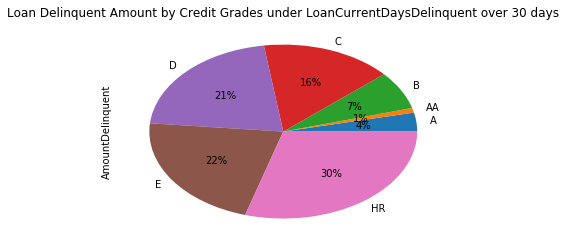

In [38]:
prosper_delinquent.plot(kind='pie', autopct='%1.0f%%')
plt.title('Loan Delinquent Amount by Credit Grades under LoanCurrentDaysDelinquent over 30 days')
plt.xticks(rotation = 90);

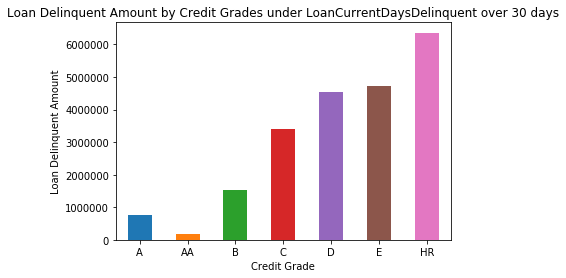

In [39]:
prosper_delinquent.plot(kind='bar')
plt.title('Loan Delinquent Amount by Credit Grades under LoanCurrentDaysDelinquent over 30 days')
plt.xlabel('Credit Grade')
plt.ylabel('Loan Delinquent Amount')
plt.xticks(rotation = 0);

**AmountDelinquent** (> 30 Delinquent Days )vs. **NewGrade**: The pie chart shows that 73% of Delinquent Amount comes from grades D (21% USD 4.5M), E(22% USD 4.7M) and HR (30% USD 6M).


### Plot 4 **yieldamount** vs. **NewGrade**

In [40]:
prosper['yieldamount'] = prosper['LenderYield']*prosper['LoanOriginalAmount']
prosper.groupby('NewGrade').yieldamount.sum()

NewGrade
A     2.138032e+07
AA    7.870802e+06
B     3.134656e+07
C     4.061349e+07
D     2.861275e+07
E     1.526154e+07
HR    9.442075e+06
NC    7.174062e+04
Name: yieldamount, dtype: float64

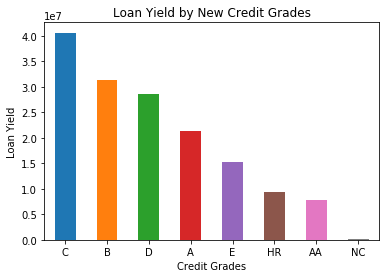

In [41]:
prosper_loanyield_grade = prosper.groupby('NewGrade').yieldamount.sum().sort_values(ascending=False)  
prosper_loanyield_grade.plot(kind='bar')
plt.title('Loan Yield by New Credit Grades')
plt.xlabel('Credit Grades')
plt.ylabel('Loan Yield')
plt.xticks(rotation = 0);

**yieldamount** vs. **NewGrade**: It’s interesting to see that  Credit Grade C provides highest **yieldamount**, followed by credit grade B, D and A, while we saw credit grade E, HR and AA have much lower **yieldamount**.

As **yieldamount** only considers **LenderYield** and **LoanOriginalAmount**, we are not sure if we can actually earn these yield because we haven't considered **AmountDelinquent** for which we possibly won't be able to collect money back.
Thus, we will use **loanprofit** which includes **yieldamount** and **AmountDelinquent** to see if the result remains the same.

### Plot 5 **loanprofit** vs. **NewGrade**

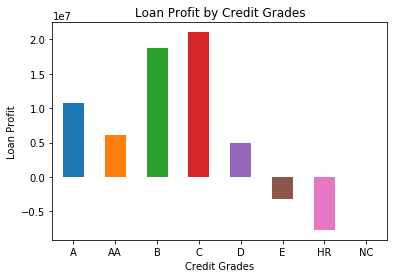

In [42]:
prosper_profit = prosper.groupby('NewGrade').loanprofit.sum()
prosper_profit.plot(kind='bar')
plt.title('Loan Profit by Credit Grades')
plt.xlabel('Credit Grades')
plt.ylabel('Loan Profit')
plt.xticks(rotation = 0);

**loanprofit** vs. **NewGrade**: The histogram chart indicates that grade C is the most profitable grade, followed B grade B, A, AA and D, while HR and E have negative profit.

### Plot 6 **LoanOriginalAmount**(LoanStatus =="Defaulted) vs. **NewGrade**

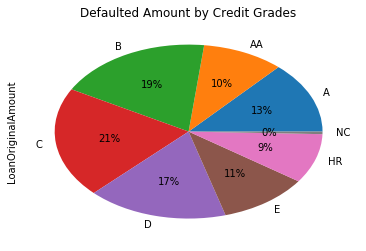

In [43]:
prosper_defaulted_grade = prosper.query('LoanOriginalAmount > 0').sort_values(by ='NewGrade', ascending = False).query('LoanStatus =="Defaulted"').groupby('NewGrade').LoanOriginalAmount.sum()
prosper_defaulted_grade.plot(kind='pie', autopct='%1.0f%%')
plt.title('Defaulted Amount by Credit Grades')
plt.xticks(fontsize=5);

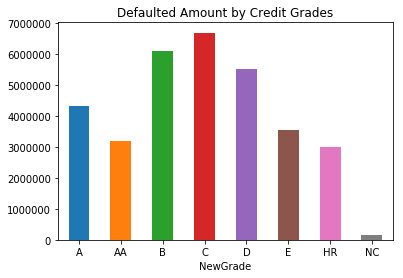

In [44]:
prosper_defaulted_grade = prosper.query('LoanOriginalAmount > 0').sort_values(by ='NewGrade', ascending = False).query('LoanStatus =="Defaulted"').groupby('NewGrade').LoanOriginalAmount.sum()
prosper_defaulted_grade.plot(kind='bar')
plt.title('Defaulted Amount by Credit Grades')
plt.xticks(rotation = 0);

**LoanOriginalAmount**(LoanStatus =="Defaulted) vs. **NewGrade**: 

Based on Defaulted **LoanStatus**, the pie chart shows that 21% of Defaulted Loan amount comes from grade C (21% USD 6.8M, followed by B (19%, USD 6M), D (17% USD 5.5M), A (13% USD 4.2M), E(11% USD 3.2M), AA (10% USD 4.3M) and HR(9% USD 3.6M). It’s interesting to see the grade A, AA and B hold 43% of Defaulted Loans, while HR only has 9%. It’s possibly that the Loan Amount to A/AA/B is generally higher than HR grade. However, it’s important for Prosper to investigate the reason of these Defaulted loans and probably add or revise the parameter when determining credit grades.

### Plot 7 **Defaulted Rate** vs. **BorrowerState** 

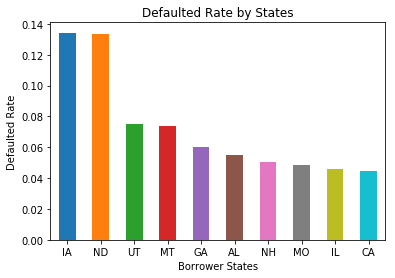

In [45]:
prosper_defaultamount = prosper.query('LoanStatus =="Defaulted"').groupby('BorrowerState').LoanOriginalAmount.sum()
prosper_defaultrate = prosper_defaultamount / prosper.groupby('BorrowerState').LoanOriginalAmount.sum()
prosper_defaultratetop10 = prosper_defaultrate.sort_values(ascending = False).head(10)
prosper_defaultratetop10.plot(kind='bar')
plt.title('Defaulted Rate by States')
plt.xlabel('Borrower States')
plt.ylabel('Defaulted Rate')
plt.xticks(rotation = 0);

To understand the ratio of Defaulted Loan, we created a new variable called prosper_defaultratetop10 which provides the top 10 ratio of Defaulted Loan compared to Total Loan amount per state. The formula is :

**LoanOriginalAmount**(LoanStatus =="Defaulted).sum() / **LoanOriginalAmount**.sum()
The result shows the states IA (Iowa) and ND (North Dakota) has the highest defaulted ratio (c.a. 13%).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

See above comments after each plot.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

-	**LoanOriginationDate** vs. **BorrowerAPR**.mean(): Although in previous section we have discussed the yearly trend of **BorrowerAPR, in this plot, based on the mean of **BorrowerAPR**, we can see that economic crisis played an crucial role before and after 2009.

 
-	**LoanOriginalAmount** vs. **NewGrade**: The pie chart shows that the total of **LoanOriginalAmount** is slightly distributed among various credit grade among B, C, D, A, AA, E and HR.  It’s noted that there are quite some of outliers at grade D, E and HR. Considering the higher chance on Delinquent possibilities, it’s important for Prosper to understand how the amount of loans is granted. 


-	**LoanOriginalAmount**(LoanStatus =="Defaulted) vs. **NewGrade: It’s interesting to see the grade A, AA and B hold 43% of Defaulted Loans, while HR only has 9%. It’s possibly that the Loan Amount to A/AA/B is generally higher than HR grade. However, it’s important for Prosper to investigate the reason of these Defaulted loans and probably add or revise the parameter when determining credit grades.


-	**Defaulted Rate vs. BorrowerState** vs. **BorrowerState** 
The result shows the states IA (Iowa) and ND (North Dakota) has the highest defaulted ratio (c.a. 13%). However, the two states stands for very little percentage of all the loans. As it’s not clear about the operational cost in each state, it’s important for Prosper to perhaps drop these states to reduce loss and operational cost.


## Multivariate Exploration

In this section, we will explore the relationship among 3 or more than 3 variables:

Plot 1 **LenderYield, BorrowerAPR, BorrowerRate**

Plot 2 **NewGrade, LoanOriginalAmount, AmountDelinquent (ReasonableResult == True)**

Plot 3 **IncomeRange, BankcardUtilization(<= 100%), DebtToIncomeRatio**

Plot 4 **NewGrade, BankcardUtilization(<= 100%), DebtToIncomeRatio**

Plot 5 **BorrowerAPR, DebtToIncomeRatio, LenderYield**

Plot 6 **BorrowerAPR, DebtToIncomeRatio, LenderYield, IsBorrowerHomeowner, DelinquenciesLast7Years, StatedMonthlyIncome, AmountDelinquent, MonthlyLoanPayment, LoanOriginalAmount, loanprofit,BankcardUtilization, IncomeVerifiable**


### Plot 1 **LenderYield**, **BorrowerAPR**, **BorrowerRate**

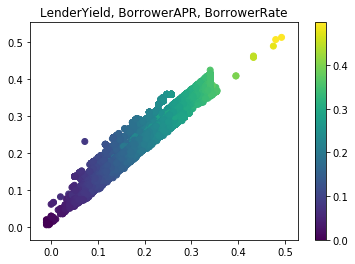

In [46]:
plt.scatter(data = prosper, x = 'LenderYield', y = 'BorrowerAPR', c = 'BorrowerRate')
plt.title('LenderYield, BorrowerAPR, BorrowerRate')
plt.colorbar();

In general, we can see a very positive and direct relationship among these three variables which is reasonable as **BorrowerRate** is the base of **LenderYield** and **BorrowerAPR**.

### Plot 2 **NewGrade**, **LoanOriginalAmount**, **AmountDelinquent** (ReasonableResult == True)

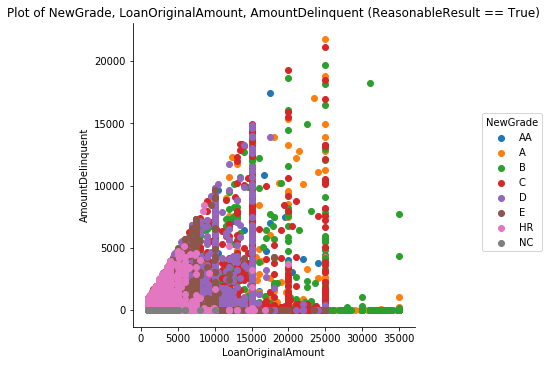

In [47]:
prosper_ReasonableResult = prosper.query('ReasonableResult == True')
NewGradeAmount = sb.FacetGrid(data = prosper_ReasonableResult, hue = 'NewGrade', size = 5, hue_order=['AA','A','B','C','D','E','HR','NC'])
NewGradeAmount.map(plt.scatter, 'LoanOriginalAmount', 'AmountDelinquent')
plt.title('Plot of NewGrade, LoanOriginalAmount, AmountDelinquent (ReasonableResult == True)')
NewGradeAmount.add_legend();

In this scatter plot, we will exclude these exceptions (ReasonableResult == True). It’s interesting to see that:
- Grade HR is mostly with **LoanOriginalAmount** lower than USD 10,000 and **AmountDelinquent** under USD 5,000.
- Grade E is mostly with **LoanOriginalAmount** lower than USD 10,000 and **AmountDelinquent** under USD 10,000.
- Grade D has quite some cases where **LoanOriginalAmount** is USD 10,000/ USD15,000 and **AmountDelinquent** under USD 10,000/ USD 15,000.  
- Grade C has quite some cases where **LoanOriginalAmount** is USD 20,000 / USD 25,000 and **AmountDelinquent** under USD 20,000 / USD 25,000.
- Grade B in general has less obvious occurrence of  **AmountDelinquent**. However, several cases are also noted that **AmountDelinquent** is spread among USD 5,000 and USD 20,000.

Overall, the higher credit grade with higher approved loan amount indicates also higher amount of delinquent.

### Plot 3 **IncomeRange**, **BankcardUtilization**(<= 100%), **DebtToIncomeRatio**

In [48]:
prosper_BankcardUtilization_Lessthan1 = prosper.query('BankcardUtilization <= 1')

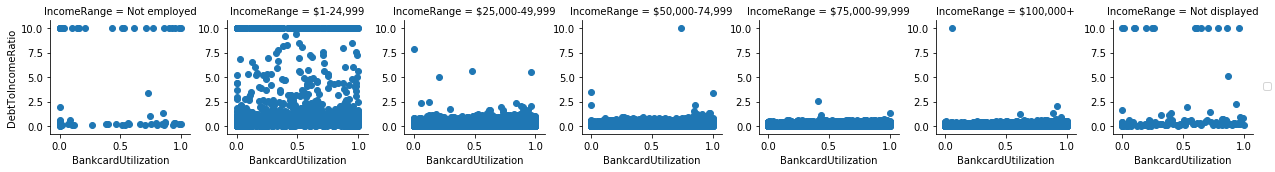

In [49]:
BorrowerHomeowner = sb.FacetGrid(data = prosper_BankcardUtilization_Lessthan1, col = 'IncomeRange', size = 2.5, 
                                 col_order = ['Not employed', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+', 'Not displayed'])
BorrowerHomeowner.map(plt.scatter,'BankcardUtilization','DebtToIncomeRatio')
BorrowerHomeowner.add_legend();

Overall, we can see that:
**BankcardUtilization** are distributed between 0%  and 100% for all **IncomeRange**.
- The lower income has higher  **DebtToIncomeRatio**
- However, for borrowers with income under USD 25,000, there is more significant **DebtToIncomeRatio**.

### Plot 4 **NewGrade**, **BankcardUtilization**(<= 100%), **DebtToIncomeRatio**

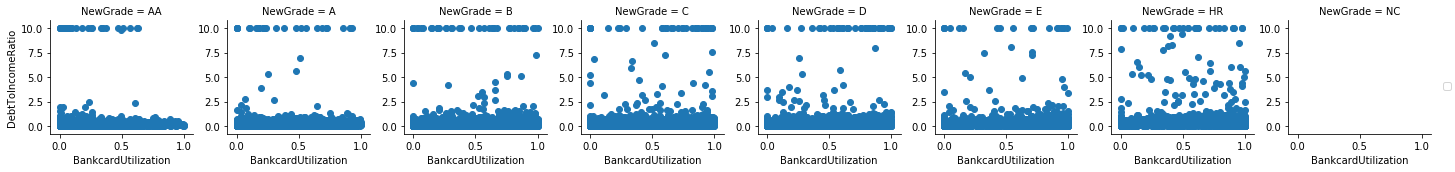

In [50]:
BorrowerHomeowner = sb.FacetGrid(data = prosper_BankcardUtilization_Lessthan1, col = 'NewGrade', size = 2.5, 
                                 col_order = ['AA','A','B','C','D','E','HR','NC'])
BorrowerHomeowner.map(plt.scatter,'BankcardUtilization','DebtToIncomeRatio')
BorrowerHomeowner.add_legend();

**BankcardUtilization** are distributed between 0%  and 100% for all **IncomeRange**.
The lower credit grades  have higher  **DebtToIncomeRatio**. Specifically, for borower with credit grade C, D, E, and HR, there is higher **DebtToIncomeRatio**.

### Plot 5 **BorrowerAPR**, **DebtToIncomeRatio**, **LenderYield**

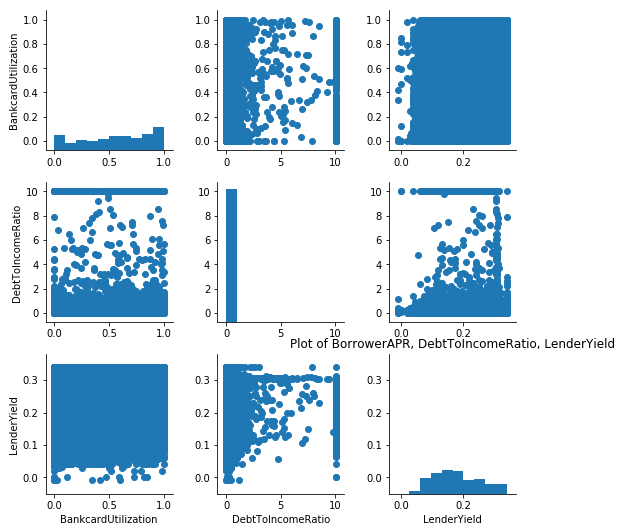

In [51]:
prosper_BankcardUtilization_Lessthan1 = prosper_BankcardUtilization_Lessthan1.dropna(axis=0, subset=['BankcardUtilization', 'DebtToIncomeRatio', 'LenderYield'])

g = sb.PairGrid(data = prosper_BankcardUtilization_Lessthan1, vars = ['BankcardUtilization', 'DebtToIncomeRatio', 'LenderYield'])
g.map_diag(plt.hist)
plt.title('Plot of BorrowerAPR, DebtToIncomeRatio, LenderYield')
g.map_offdiag(plt.scatter);
#prosper_BankcardUtilization_Lessthan1[prosper_BankcardUtilization_Lessthan1['BankcardUtilization'].isnull()]

In general, there is no obvious relationship among these three variable. However, we can still see the trend of he higher **DebtToIncomeRatio**, the higher **LenderYield**. It’s possibly that borrowers who have higher **DebtToIncomeRatio** would be willing to pay higher interest rate. 

### Plot 6 **BorrowerAPR, DebtToIncomeRatio, LenderYield, IsBorrowerHomeowner, DelinquenciesLast7Years, StatedMonthlyIncome, AmountDelinquent, MonthlyLoanPayment, LoanOriginalAmount, loanprofit,BankcardUtilization, IncomeVerifiable**

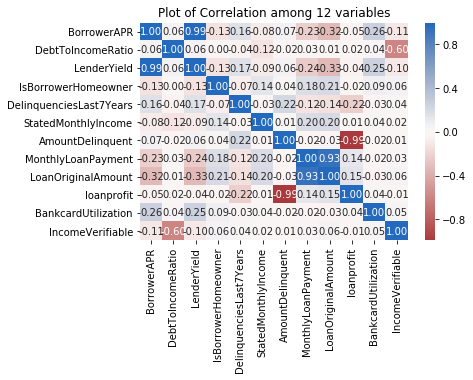

In [52]:
prosper1 = prosper[['BorrowerAPR', 'DebtToIncomeRatio', 'LenderYield','IsBorrowerHomeowner','DelinquenciesLast7Years',
                    'StatedMonthlyIncome','AmountDelinquent','MonthlyLoanPayment','LoanOriginalAmount','loanprofit','BankcardUtilization','IncomeVerifiable']]
sb.heatmap(prosper1.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.title('Plot of Correlation among 12 variables');

In this analysis, we add 12 variables to understand the correlations among each other. There are some moderate correlations (over +- 0.3) noted:
-	**AmountDelinquen** has strongly negative relationship with **loanprofit** (-0.99).
-	**BorrowerAPR** /** LenderYield **   has moderately negative relationship (-0.32 / -0.33) with ** LoanOriginalAmount**.
In general, there is no surprising relationship is noted based on this analysis. Most relationship is acknowledged in previous discussion.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) interest?

-	**LenderYield**, **BorrowerAPR**, **BorrowerRate**: strongly direct and positive relationship among each other.

### Were there any interesting or surprising interactions between features?

-	**NewGrade**, **LoanOriginalAmount**, **AmountDelinquent** (ReasonableResult == True): It’s interesting to see that Grade C and D have quite some cases where **LoanOriginalAmount** is USD 10,000/ USD15,000 / USD 20,000 / USD 25,000 and **AmountDelinquent** under USD 10,000/ USD 15,000 / USD 20,000 / USD 25,000. They are not at lowest credit grade, but able to borrow higher loan amount. Thus it’s important for Prosper to pay more attention when granting loans with these borrowers.
  
-	**BorrowerAPR**, **DebtToIncomeRatio**, **LenderYield**: 
In general, there is no obvious relationship among these three variable. However, we can still see the trend of he higher **DebtToIncomeRatio**, the higher **LenderYield**. It indicates that borrowers who have higher **DebtToIncomeRatio** would be more willing to pay higher interest rate. 


## Limitations and Conclusions:

### 1)	Limitation:
•	As indicated at Step 2, we would like to calculate Profit for each loan according to Yield rate, Original Loan amount and AmountDelinquent. However, it’s noted that 4,635 loans have (much) higher AmountDelinquent than Original Loan amount. It’s important to understand the reason of such deviation. However, due to the insufficient information provided, we can’t explain further about this deviation.

•	Moreover, to have deeper analysis on borrowers’ background, Prosper might avoid general categories for borrowers to fill information, such as **occupation** where majority of borrowers fill with Others/Professional.Thus, it's not easy to identify potential borrowers by the type of occupation.

### 2)	Conclusion / Actions:

•	It’s important for Prosper to investigate the approval process of granting loans with lower credit grades but high loan amount, especially with grades E and HR. The result of analysis on AmountDelinquent indicates that Prosper could possibly avoid loss from loans.

•	For those Defaulted loans but with grade AA/A, it’s important for Prosper to investigate further on the reason causing default, so we can reduce the risk of loss. Or Prosper might review the appropriateness of approach of credit grades. Based on these feedback, Prosper can consider new parameters in the future. 

•	Overall, we can see the borrowers with credit grades C with good profit where majority of borrowers have income between USD 3,000 and USD 5,000. It would be beneficial for Prosper to increase the percentage of such borrowers.

•	Furthermore, as we can see that the majority of the borrowers is located in CA (California) where is also Prosper’s Headquarter. Considering the higher loan profit and resource utilization, it might be another consideration for Prosper to focus loan business on for example top 10 states and reduce business in states with lower profit which might take more resources with less positive output.



In [53]:
prosper.to_csv('prosper_cleandata', index = False)

In [54]:
pd.options.display.max_columns = None
prosper.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRatingAlpha,ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewGrade,loanprofit,ReasonableResult,LoanOriginationYear,yieldamount
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258,C,828.65,True,2007,1300.65
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaT,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14.000,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1,A,820.00,True,2014,820.00
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41,HR,720.24,True,2007,720.24
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaT,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32.000,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158,A,-9182.00,False,2012,874.00
4,0F023589499656230C5E3E2,909464,2013-09-14 18:3

In [57]:
prosper.shape

(113066, 86)